In [ ]:
!pip install datasets evaluate sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 9.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires f

In [ ]:
import evaluate
from datasets import Dataset, concatenate_datasets
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import MarianMTModel, MarianTokenizer
from transformers import DataCollatorForSeq2Seq
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
from peft import PeftModel, PeftConfig, get_peft_model, LoraConfig
from sklearn.model_selection import train_test_split

In [ ]:
ds = load_dataset("facebook/flores", "eng_Latn-ukr_Cyrl")
print(ds)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/11.8k [00:00<?, ?B/s]

flores.py:   0%|          | 0.00/11.2k [00:00<?, ?B/s]

The repository for facebook/flores contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/facebook/flores.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating dev split: 0 examples [00:00, ? examples/s]

Generating devtest split: 0 examples [00:00, ? examples/s]

DatasetDict({
    dev: Dataset({
        features: ['id', 'URL', 'domain', 'topic', 'has_image', 'has_hyperlink', 'sentence_eng_Latn', 'sentence_ukr_Cyrl'],
        num_rows: 997
    })
    devtest: Dataset({
        features: ['id', 'URL', 'domain', 'topic', 'has_image', 'has_hyperlink', 'sentence_eng_Latn', 'sentence_ukr_Cyrl'],
        num_rows: 1012
    })
})


In [ ]:
combined_dataset = concatenate_datasets([ds["dev"], ds["devtest"]])
combined_dataset[1]

{'id': 2,
 'URL': 'https://en.wikinews.org/wiki/Scientists_say_new_medical_diagnostic_chip_can_sort_cells_anywhere_with_an_inkjet',
 'domain': 'wikinews',
 'topic': 'health',
 'has_image': 0,
 'has_hyperlink': 0,
 'sentence_eng_Latn': 'Lead researchers say this may bring early detection of cancer, tuberculosis, HIV and malaria to patients in low-income countries, where the survival rates for illnesses such as breast cancer can be half those of richer countries.',
 'sentence_ukr_Cyrl': 'Провідні дослідники кажуть, що це може сприяти ранньому виявленню раку, туберкульозу, ВІЛ і малярії у пацієнтів з країн з низьким рівнем доходу, де показники виживання людей з такими захворюваннями, як рак грудей, можуть бути вдвічі нижчі, ніж у заможніших країнах.'}

In [ ]:
dataset = combined_dataset.train_test_split(test_size=0.2)

In [ ]:
dataset.shape

{'train': (1607, 8), 'test': (402, 8)}

In [ ]:
model_name = "Helsinki-NLP/opus-mt-en-uk"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/809k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/1.01M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.37M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/305M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

In [ ]:
prefix = "translate English to Ukrainian: "


def preprocess_function(examples):
    inputs = examples['sentence_eng_Latn']
    targets = examples['sentence_ukr_Cyrl']
    model_inputs = tokenizer(inputs, max_length=256, truncation=True)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=256, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


In [ ]:
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))

tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/1607 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3970: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/402 [00:00<?, ? examples/s]

In [ ]:
print(tokenized_dataset.column_names)

{'train': ['id', 'URL', 'domain', 'topic', 'has_image', 'has_hyperlink', 'sentence_eng_Latn', 'sentence_ukr_Cyrl', 'input_ids', 'attention_mask', 'labels'], 'test': ['id', 'URL', 'domain', 'topic', 'has_image', 'has_hyperlink', 'sentence_eng_Latn', 'sentence_ukr_Cyrl', 'input_ids', 'attention_mask', 'labels']}


In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model_name)

In [ ]:
import peft
peft_config = LoraConfig(task_type="SEQ_2_SEQ_LM",
                        r=32,
                        lora_alpha=64,
                        lora_dropout=0.001,
                        target_modules = 'all-linear')

In [ ]:
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 4,325,376 || all params: 80,520,704 || trainable%: 5.3718


In [ ]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers import EarlyStoppingCallback

training_args = Seq2SeqTrainingArguments(
    output_dir="/fine_tuned_Helsinki_en_uk",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    learning_rate=1e-5,
    num_train_epochs=25,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    remove_unused_columns=True,
    optim="adamw_torch",
    report_to="none",
    logging_strategy="epoch",
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

<ipython-input-33-089daf87bd57>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,1.949800,1.780030
2,1.956400,1.774577
3,1.946400,1.769370
4,1.928400,1.765393
5,1.915100,1.761718
6,1.913100,1.758984
7,1.895200,1.756392
8,1.904800,1.753811
9,1.895000,1.751641
10,1.891100,1.750022


TrainOutput(global_step=650, training_loss=1.8893243408203124, metrics={'train_runtime': 433.3655, 'train_samples_per_second': 92.705, 'train_steps_per_second': 1.5, 'total_flos': 683754379739136.0, 'train_loss': 1.8893243408203124, 'epoch': 25.0})

In [ ]:
log_history = trainer.state.log_history

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
epochs = []
training_loss = []
validation_loss = []

train_losses = {}
val_losses = {}

In [ ]:
for entry in log_history:
    epoch = int(entry["epoch"])

    if "loss" in entry:
        train_losses[epoch] = entry["loss"]
    if "eval_loss" in entry:
        val_losses[epoch] = entry["eval_loss"]

In [ ]:
epochs = sorted(train_losses.keys())
training_loss = [train_losses[e] for e in epochs]
validation_loss = [val_losses[e] for e in epochs]

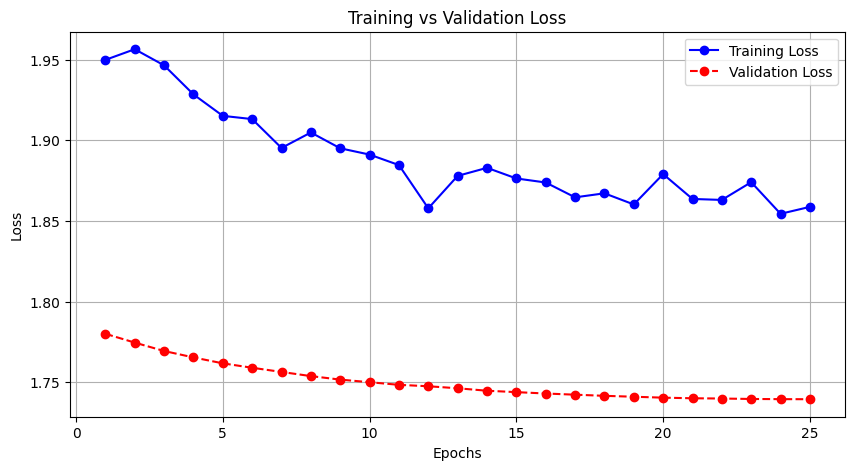

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_loss, label="Training Loss", marker='o', linestyle='-', color="blue")
plt.plot(epochs, validation_loss, label="Validation Loss", marker='o', linestyle='--', color="red")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.show()

In [ ]:
model.save_pretrained("fine_tuned_helsinki_2")
tokenizer.save_pretrained("fine_tuned_helsinki_2")

('fine_tuned_helsinki_2/tokenizer_config.json',
 'fine_tuned_helsinki_2/special_tokens_map.json',
 'fine_tuned_helsinki_2/vocab.json',
 'fine_tuned_helsinki_2/source.spm',
 'fine_tuned_helsinki_2/target.spm',
 'fine_tuned_helsinki_2/added_tokens.json')

In [ ]:
import shutil

shutil.make_archive("fine_tuned_helsinki", "zip", "fine_tuned_helsinki_2")
from google.colab import files
files.download("fine_tuned_helsinki.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>